# Segmentation of Medical Scans using Variational VAE's
This notebook goes through the process of creating a pytorch-compatible dataset, and setting up a model for segmentation of tumors in various organs. It enables reproduceability of our final model and testing results.

---

## 0. Setup
We import some necessary libraries.

In [1]:
# For ML
import torch
from torch import Tensor
import torchvision.transforms as Transform

# For reading raw data.
import json
import nibabel as nib

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt

# For monitoring resource-usage and progress.
from tqdm import tqdm
import os, sys, psutil
from os.path import join, exists


Check if GPU is available and retrieve some system stats.

In [2]:
# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce GTX 1070
CUDA version: 11.7
RAM: 16.74GB


Making sure, we are in the correct working directory.

In [3]:
!pwd

/media/nv/Storage/Data-Science/vae_lung_tumor_segmentation/net_md


Setting up some global constants.

In [4]:
root_dir = './' # Location of project, relative to the working directory.
raw_data_dir = join(root_dir, 'data', 'raw_data')
prep_data_dir = join(root_dir, 'data', 'prep_data')
model_dir = join(root_dir, 'model')
stats_dir = join(root_dir, 'stats')
output_dir = join(root_dir, 'output')

organs = ['spleen']

d = 256 # New dimensions (width and height) of datapoints.
num_chunks = 16 # Number of chunks to divide our data into.

We define a function to load current progress, as to not repeat work, which has already been completed, when running the entire notebook at once. The progress flags are stored externally in `progression.json`.

In [5]:
def get_progress():
    with open('progress.json','r') as f:
        return json.load(f)

def set_progress(progress):
    with open('progress.json', "w") as f: 
        json.dump(progress, f, indent=4)

We setup a folder structure for our data - both raw and preprocessed.

In [6]:
if not exists(prep_data_dir): os.makedirs(prep_data_dir)
if not exists(output_dir): os.makedirs(output_dir)
if not exists(model_dir): os.makedirs(model_dir)

if not exists(raw_data_dir):
    os.mkdir(raw_data_dir)
    for organ in organs:
        os.mkdir(os.path.join(raw_data_dir, organ))

The `raw_data/` sub-directories for each organ has to be populated manually using the unzipped files from [medicaldecathlon.com](https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2)

---

## 1. Inspecting the Data

---

## 2. Preparing Data

We define a function which loads and stores our data in the proper formatting. As the datasets are huge and have to concatenate each set of 240 slices to the previous, we monitor progress and RAM-usage.

In [10]:
def prep_data(prefix, mode, organ, manifest, transform, bar):
    images = torch.zeros((0, d, d))

    for entry in manifest:
        bar.set_postfix(**{'RAM':round(psutil.virtual_memory()[3]/10e8, 2)})
        bar.update()

        nii_img = nib.load(join(raw_data_dir, organ, entry[prefix][2:]))

        # Convert to numpy array, then pytorch tensor.
        nii_data = Tensor(nii_img.get_fdata())
        nii_data = nii_data.permute(2, 0, 1) # Shape: (slice, rows, columns)
        nii_data = transform(nii_data)
        images = torch.cat((images, nii_data), 0)
    
    print('Saving', organ, mode, prefix, 'slices...')
    torch.save(images, 
        join(prep_data_dir, mode, organ + '_' + prefix + '_slices.pt'))

We prep and format datasets from raw data for each specified organ, using the above function. We save progress after each organ is completed. Can be interrupted and resumed at any time, and accounts for progress, which has already been made.

In [11]:
progress = get_progress()
resize = Transform.Resize((d, d))
mode = 'train'

for organ in organs:
    if not progress['preprocessed'][organ]:

        organ_path = join(raw_data_dir, organ)
        file = join(organ_path, 'dataset.json')
        with open(file) as f:
            manifest = json.load(f)['training']

        bar = tqdm(total=2*len(manifest))
        bar.set_description(f'%s' % organ)

        try: 
            prep_data('image',mode,organ,manifest,resize,bar)
            prep_data('label',mode,organ,manifest,resize,bar)
            bar.close()
            print('The', organ, 'was successfully loaded.')

            progress['preprocessed'][organ] = True
            set_progress(progress)
            
        except KeyboardInterrupt:
            print ('Manually stopped.\nOrgan:', organ, 'was not saved.')
            bar.close()
            break
    else:
        print('The', organ, 'set has already been loaded.')

spleen:  51%|█████     | 42/82 [00:26<00:34,  1.15it/s, RAM=2.71]

Saving spleen train image slices...


spleen: 100%|██████████| 82/82 [00:36<00:00,  2.26it/s, RAM=3.71]

Saving spleen train label slices...
The spleen was successfully loaded.


---

The datasets are so large, that we need to split them into smaller chunks. We first initialize empty chunks, and fill them with augmented data from each organ, evenly split amongst the chunks.

```progress = get_progress()

if not progress['chunked']:
    for n in range(num_chunks):
        chunk = torch.zeros(0, d, d)
        torch.save(chunk, join(prep_data_dir, f'unaugmented_chunk_{n}.pt'))

    bar = tqdm(total=len(organs)*num_chunks)
    bar.set_description(f'Augmentation')
    
    try:
        for organ in organs:
            data = torch.load(join(prep_data_dir,organ+ '_slices_unaugmented.pt'))
            N = data.shape[0]
            idx = torch.randperm(N)
            data = data[idx]
            split_idx = int(N/num_chunks)
            
            for n in range(num_chunks):
                path = join(prep_data_dir, f'unaugmented_chunk_{n}.pt')
                chunk = torch.load(path)
                chunk = torch.cat((chunk, data[n*split_idx:(n+1)*split_idx]), 0)
                torch.save(chunk, path)
                bar.update()

        print('Chunking was successful.')

        # Change state of progression.json
        progress['chunked'] = True
        set_progress(progress)
            
    except KeyboardInterrupt:
        print ('Manually stopped.\nChunk', str(n), 'was not saved.')
        bar.close()
        
else:
    print('Data augmentation and chunking already completed.')
```

---

## 3. Dataset Management
We define a custom dataset class that is applicable for any organ.

In [12]:
from torch.utils.data import Dataset
import gzip

class CT_Dataset(Dataset):
    def __init__(self, path, organ, lod):
        self.images = torch.load(join(path,organ + '_image_slices.pt'))
        self.labels = torch.load(join(path,organ + '_label_slices.pt'))
        self.length = len(self.images)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return {'x': self.images[index], 't': self.labels[index]}

    def visualize(self,index):
        sample = self.__getitem__(index)
        fig, ax = plt.subplots(1, 2, figsize=(8,5))
        image = sample['x'].detach().numpy()
        label = sample['t'].detach().numpy()
        ax[0].imshow(image, interpolation='nearest')
        ax[1].imshow(label, interpolation='nearest')
        fig.canvas.draw()


We create an instance, and inspect if its output makes sense.

In [34]:
# Careful running this. Will take up a lot of RAM for some of the organs.
dataset = CT_Dataset(join(prep_data_dir,'train'), 'spleen', 8)

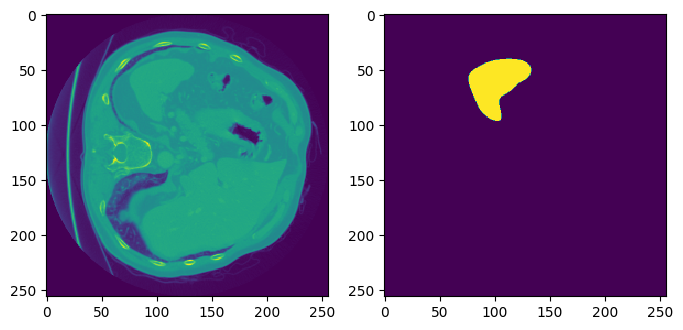

In [35]:
dataset.visualize(1000)

---

# 4. Creating Model Architecture
We first import the necessary architecture-components from pytorch.

In [ ]:
from torch.nn import Module, ModuleList, Conv2d, ConvTranspose2d, Linear

We define our model architecture for the segmenting variational autoencoder, which consists of an encoder and two separate decoders, so it makes sense to define each component as their own class, i.e. pytorch module. We start with the encoder.

In [ ]:
class Encoder(Module):
    def __init__(self, shape, initial):
        super(Encoder, self).__init__()
        self.shape = shape
        self.initial = initial

        self.downsample_block = ModuleList()
        self.mu_encoding_block = ModuleList()
        self.var_encoding_block = ModuleList()

        for level in range(int(np.log2(self.shape[1])-1)):
            if level == 0:
                self.downsample_block.append(
                    Conv2d(in_channels=self.shape[0], out_channels=initial, kernel_size=4, stride=2, padding=1))
            else:
                self.downsample_block.append(
                    Conv2d(in_channels=initial*2**(level-1), out_channels=initial*2**(level), kernel_size=4, stride=2, padding=1))

            features, length = self.initial*2**(level+2), int(2**(level+2))
            
            self.mu_encoding_block.append(
                Linear(in_features=features, out_features=length))
            
            self.var_encoding_block.append(
                Linear(in_features=features, out_features=length))
    
    def encode(self, x, scale):
        for layer in range(scale):
            x = self.downsample_block[layer](x)
            
        x = self.downsample_block[scale](x)
        shape = x.shape
        x = torch.flatten(x, start_dim=1)
        mu = (self.mu_encoding_block[scale](x))
        log_var = (self.var_encoding_block[scale](x))
        
        return mu, log_var, shape

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # Reparameterization.
        epsilon = torch.randn_like(std)
        return mu + std * epsilon # z

    def forward(self, x, scale):
        mu, log_var, shape = self.encode(x, scale)
        z = self.sample(mu, log_var)
        return z, mu, log_var, shape

And then the decoder architecture.

In [ ]:
class Decoder(Module):
    def __init__(self, shape, initial, act):
        super(Decoder, self).__init__()
        self.act = act
        self.shape = shape
        self.initial = initial

        self.conv_upsample_block = ModuleList()
        self.z_decoding_block = ModuleList()

        for level in range(int(np.log2(self.shape[1])-1)):
            if level == 0:
                self.conv_upsample_block.append(
                    ConvTranspose2d(in_channels=initial, out_channels=self.shape[0], kernel_size=4, stride=2, padding=1))
            else:
                self.conv_upsample_block.append(
                    ConvTranspose2d(in_channels=int(initial*2**(level)), out_channels=int(initial*2**(level-1)), kernel_size=4, stride=2, padding=1))

            features, length = self.initial*2**(level+2), int(2**(level+2))

            self.z_decoding_block.append(
                Linear(in_features=length, out_features=features))
    
    def decode(self, z, scale, shape):
        x = self.act(self.z_decoding_block[scale](z)).reshape(shape)
        
        for layer in range(scale): # Transposed convolutions.
            x = self.act(self.conv_upsample_block[scale-layer](x))
        x = self.conv_upsample_block[0](x)

        return x

    def forward(self, z, scale, shape, detach=False):
        if detach: z = z.detach()
        x = self.decode(z, scale, shape)
        return x

Finally, we use these two in combination to create our variational autoencoder.

In [ ]:
class VAE(Module):
    def __init__(self, shape, initial, act):
        super(VAE, self).__init__()
        self.encoder = Encoder(shape, initial)
        self.decoder = Decoder(shape, initial, act)
        self.segmenter = Decoder(shape, initial, act)

    def forward(self, x, lod, print=False):
        lod = lod - 2
        z, mu, log_var, shape = self.encoder.forward(x, lod)
        
        x_reconst = torch.sigmoid(
            self.decoder.forward(z, lod, shape))
        
        x_segment = torch.sigmoid(
            self.segmenter.forward(z, lod, shape, detach=True))

        if print: print(z)
        
        return ((x_reconst, mu, log_var), x_segment)

# 5. Defining Training- and Evaluation Routines
We define a class, which contain our testing routine, checkpoint management, evaluation routine, and some utility functions. This will allow us to easily run tests with different hyperparameters. 

In [ ]:
class Test():
    def __init__(self, model, dir, load, optimizer, criterions, iou_thresh):
        self.model = model
        self.dir = dir
        self.optimizer = optimizer
        self.device = device
        self.criterions = criterions
        self.io_thresh = iou_thresh
        
        if load: 
            self.load_checkpoint(os.path.join(self.dir, 'checkpoint.pt'))
        
        self.model.to(self.device)

    def train(self, dataloader, epochs, lod, print_at=10):
        for epoch in range(epochs):
            batch_count = 0
            losses = np.array([0] * len(self.criterions), dtype=np.float32)

            for batch in dataloader:
                print(np.shape(batch))
                y = self.model.forward(batch['x'].to(self.device), lod)

                # Backpropagation
                self.model.zero_grad()
                for i, value in enumerate(zip(y, self.criterions, batch)):
                    output, criterion, key = value
                    loss = criterion(output, batch[key].to(self.device))
                    loss.backward()
                    losses[i] += loss

                self.optimizer.step()
                batch_count += 1

            if ((epoch % print_at) == 0):
                losses = losses / batch_count
                print('Epoch: ' + epoch, 'Reconst/kld loss: ' + losses[0], 
                      'Seg loss: ' + losses[1])

    def IoU(self, label, reconst):
        i = ((label >= self.iou_thresh) & (reconst >= self.iou_thresh)) * 1.0
        u = ((label >= self.iou_thresh) | (reconst >= self.iou_thresh)) * 1.0
        return i.sum() / u.sum() / label.shape[0]

    def evaluate(self, dataloader, lod):
        batch_count = 0
        losses = np.array([0] * len(self.criterions), dtype=np.float32)
        iou = 0
        for batch in dataloader:
            y = self.model.forward(batch['x'].to(self.device), lod)

            for i, value in enumerate(zip(y, self.criterions, batch)):
                output, criterion, key = value
                loss = criterion(output, batch[key].to(self.device))
                losses[i] += loss
            
            iou += self.IoU(batch['t'].to(self.device), y[1])
            batch_count += 1
        
        losses /= batch_count
        iou /= batch_count
        print('Reconst/kld loss:', losses[0], 'Seg loss:', losses[1], 'IoU:', iou)
    
    def load_checkpoint(self, path):
        cp = torch.load(path)
        self.model.load_state_dict(cp['model_state_dict'])
        self.optimizer.load_state_dict(cp['optimizer_state_dict'])
        
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.cuda()

    def save_checkpoint(self):
        path = os.path.join(self.dir, 'checkpoint.pt')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, path)

    def reconstruct(self, dataloader, lod, count):
        batch = next(iter(dataloader))
        count = min(count, len(batch['x']))
        x = batch['x'][:count].to(self.device)
        t = batch['t'][:count].to(self.device)
        y = self.model.forward(x, lod)
        x_reconst = y[0][0]
        x_segment = y[1]
        return x, t, x_reconst, x_segment

    def save_reconst(self, dataloader, lod, count, output_dir):
        x_ins, t_ins, x_outs, t_outs = self.reconstruct(dataloader, lod, count)
        x_ins = x_ins.detach().cpu().numpy()
        t_ins = t_ins.detach().cpu().numpy()
        x_outs = x_outs.detach().cpu().numpy()
        t_outs = t_outs.detach().cpu().numpy()
        
        for i, value in enumerate(zip(x_ins, t_ins, x_outs, t_outs)):
            x_in, t_in, x_out, t_out = value

            x = np.stack([x_in]*3, axis=0).squeeze().transpose((1,2,0))
            t = np.stack([t_in]*3, axis=0).squeeze().transpose((1,2,0))
            
            mask = t[..., 0] > self.iou_thresh
            x[mask] = np.array([0, 1, 0.5])*t[mask]
            
            plt.imsave(join(output_dir, 
                'input_' + str(i) + 'resolution_' + str(2**lod) + '.png'), x)

            x_r = np.stack([x_out]*3, axis=0).squeeze().transpose((1,2,0))
            t_r = np.stack([t_out]*3, axis=0).squeeze().transpose((1,2,0))
            
            mask = t_r[..., 0] > self.iou_thresh
            x_r[mask] = np.array([0, 1, 0.5])*t[mask]
            
            plt.imsave(join(output_dir,
                'output_' + str(i) + 'resolution_' + str(2**lod) + '.png'), x_r)

We also define a custom loss function.

In [ ]:
def loss_function(output, x):
    recon_x, mu, log_var = output
    batchSize = mu.shape[0]
    rl = (recon_x - x).pow(2).sum() / batchSize
    kld = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp()) / batchSize
    return rl + kld

---

# 6. Putting it all together
We pass our custom datasets to pytorch dataloaders. 

In [ ]:
from torch.utils.data import DataLoader

batchSize = 64
num_workers = 2

train_loader = DataLoader(
    dataset=dataset, batch_size=batchSize,
    shuffle=True, num_workers=num_workers
)


In [ ]:
from torch.nn.functional import elu
from torch.optim import Adam

model = VAE((1, d, d), 16, elu)

test = Test(
    model=model,
    dir=model_dir,
    load=False, 
    optimizer=Adam(model.parameters(), lr=0.001), 
    criterions=[loss_function, torch.nn.BCELoss()], 
    iou_thresh=0.2)

In [ ]:
epochs = 10
lod = 8
iterations = 1

for i in range(iterations):
    pass
    #test.train(train_loader, epochs, lod, 1)
    #test.evaluate(test_loader, lod)
    #test.save_reconst(test_loader, lod, 10, output_dir)
    #test.save_checkpoint()